<div style="page-break-after: always;"></div>

# <center>DATA1030 Final Project Report -- Hand Gesture Recognition</center>
<center>Cangcheng Tang</center>
<center>Banner ID: B01628536</center>

In [539]:
import pandas as pd
import numpy as np
import time
import shap
from sklearn.preprocessing import MinMaxScaler
import xgboost
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
shap.initjs() # required for visualizations later on

# 1. Load Data and Check baseline

In [4]:
df = pd.read_csv('../data/Original Postures Data.csv')
df = df.drop(0)    # Dropping initial dummy record
df = df.replace('?', np.NaN)    # Replacing missing value with NaN
df = df.drop(['X11','Y11', 'Z11'], axis=1)    # Drop marker 11, almost missing 100%
df['Missing_marker_num'] = df.isnull().sum(axis=1)    # Add a new column for # of missing markers
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,Missing_marker_num
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18


In [5]:
baseline_class = list(df['Class'].value_counts()/df.shape[0])[0]
baseline_user = list(df['User'].value_counts()/df.shape[0])[0]
print(f"Baselin for Class: {100*baseline_class}%")
print(f"Baselin for User: {100*baseline_user}%")

Baselin for Class: 20.928356488891733%
Baselin for User: 12.258147128497344%


# 2. Prediction

## 2.1 Training Models for Class

### 2.1.1 xgboost

#### 2.1.1.1 Split train, cv, test for XGB

In [369]:
scaler_minmax = MinMaxScaler()
coord_column = df.columns[2:]
impute_feat = list(df.columns[0:17])
impute_feat.append('Missing_marker_num')

def extract_data(ls, ref_col, pred_col, drop_ref=True, impute=False, random_state=42):
    """Extract data according to the given list ls"""
    print('proportion:', sum([len(df[df[ref_col] == i]) for i in ls])/df.shape[0])    # The proportion of extracted data
    df_split = df.loc[df[ref_col].isin(ls)]    # Get split set
    # drop referenced column
    if drop_ref:
        df_split.drop(ref_col, axis=1, inplace=True)
    x_split = df_split.drop(pred_col, axis=1)    # Get x_split
    y_split = df_split[[pred_col]]    # Get y_split
    print('rows:', df_split.shape[0])
    if impute:
        return x_split.drop(x_split.columns[15:33], axis=1), y_split
    else:
        return x_split, y_split

In [366]:
# User 0, 1, 2, 4, 5, 6, 7, 9, 11, 14 as training set, 57.51% of all the data
class_train_list = [0, 1, 2, 4, 5, 6, 7, 9, 12, 14]
print("Train")
x_class_train, y_class_train = extract_data(class_train_list, 'User', 'Class')
x_class_train[coord_column] = scaler_minmax.fit_transform(x_class_train[coord_column])    # Standarize coordinates
print("########################################")

# User 8, 10 as test set, 20.98% of all the data
class_test_list = [8, 10]
print("Test: ")
x_class_test, y_class_test = extract_data(class_test_list, 'User', 'Class')
x_class_test[coord_column] = scaler_minmax.transform(x_class_test[coord_column])    # Standarize coordinates
print("########################################")

# User 11, 13 as CV set, 21.51% of all the data
class_cv_list = [11, 13]
print("CV")
x_class_cv, y_class_cv = extract_data(class_cv_list, 'User', 'Class')
x_class_cv[coord_column] = scaler_minmax.transform(x_class_cv[coord_column])    # Standarize coordinates

Train
proportion: 0.5750816313464371
rows: 44911
########################################
Test: 
proportion: 0.2097957615724438
rows: 16384
########################################
CV
proportion: 0.21512260708111916
rows: 16800


#### 2.1.1.2 Tune hyperparameters
Find the best $\alpha$, $\lambda$ and `max_depth` for xgboost.  

In [334]:
xgb_para = {"XGB": [], "lambda": [], "depth": [], "accuracy_cv": []}
for lbd in [0e0, 1., 10.0, 20.0, 50.0]:
    for depth in [4, 5, 6, 7, 8]:
        param_grid = {"learning_rate": [0.03],
                      "n_estimators": [400],
                      "seed": [42],
                      "reg_alpha": [0e0],
                      "reg_lambda": [lbd],
                      "missing": [np.NaN], 
                      "max_depth": [depth],
                      "colsample_bytree": [0.9],              
                      "subsample": [0.66], 
                      "n_jobs": [-1]}
        XGB = xgboost.XGBClassifier()
        XGB.set_params(**ParameterGrid(param_grid)[0])
        XGB.fit(x_class_train, y_class_train, early_stopping_rounds=50, 
                eval_set=[(x_class_cv, y_class_cv)], verbose=False)
        y_class_cv_pred = XGB.predict(x_class_cv)
        xgb_para["accuracy_cv"].append(accuracy_score(y_class_cv, y_class_cv_pred))
        xgb_para["XGB"].append(XGB)
        xgb_para["lambda"].append(lbd)
        xgb_para["depth"].append(depth)
        print(f"lambda: {lbd}, depth: {depth} finished")

lambda: 0.0, depth: 4 finished
lambda: 0.0, depth: 5 finished
lambda: 0.0, depth: 6 finished
lambda: 0.0, depth: 7 finished
lambda: 0.0, depth: 8 finished
lambda: 1.0, depth: 4 finished
lambda: 1.0, depth: 5 finished
lambda: 1.0, depth: 6 finished
lambda: 1.0, depth: 7 finished
lambda: 1.0, depth: 8 finished
lambda: 10.0, depth: 4 finished
lambda: 10.0, depth: 5 finished
lambda: 10.0, depth: 6 finished
lambda: 10.0, depth: 7 finished
lambda: 10.0, depth: 8 finished
lambda: 20.0, depth: 4 finished
lambda: 20.0, depth: 5 finished
lambda: 20.0, depth: 6 finished
lambda: 20.0, depth: 7 finished
lambda: 20.0, depth: 8 finished
lambda: 50.0, depth: 4 finished
lambda: 50.0, depth: 5 finished
lambda: 50.0, depth: 6 finished
lambda: 50.0, depth: 7 finished
lambda: 50.0, depth: 8 finished


#### 2.1.1.3 Uncertainty created by random state on splitting and xgboost and final results

In [336]:
# Best XGB model
xgb_para['XGB'][np.argmax(xgb_para['accuracy_cv'])]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.0, reg_lambda=10.0, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.66, verbosity=1)

In [402]:
def uncertainty_xgb_class(test, train, cv, random_state):
    """Return the result of xgb model given how the user wants to split train, cv, test and random_state of xgb"""
    x_class_test, y_class_test = extract_data(test, 'User', 'Class')    # Split test
    x_class_train, y_class_train = extract_data(train, 'User', 'Class')    # Split train
    x_class_cv, y_class_cv = extract_data(cv, 'User', 'Class')    # Split cv
    x_class_train[coord_column] = scaler_minmax.fit_transform(x_class_train[coord_column])    # Standarize coordinates
    x_class_test[coord_column] = scaler_minmax.transform(x_class_test[coord_column])    # Standarize coordinates
    x_class_cv[coord_column] = scaler_minmax.transform(x_class_cv[coord_column])    # Standarize coordinates
    param_grid = {"learning_rate": [0.03],
                          "n_estimators": [400],
                          "seed": [random_state],
                          "reg_alpha": [0e0],
                          "reg_lambda": [10.],
                          "missing": [np.NaN], 
                          "max_depth": [6],
                          "colsample_bytree": [0.9],              
                          "subsample": [0.66], 
                          "n_jobs": [-1]}
    XGB = xgboost.XGBClassifier()
    XGB.set_params(**ParameterGrid(param_grid)[0])
    XGB.fit(x_class_train, y_class_train, early_stopping_rounds=50, 
            eval_set=[(x_class_cv, y_class_cv)], verbose=False)
    y_class_test_pred = XGB.predict(x_class_test)    # Get result from test set
    return accuracy_score(y_class_test, y_class_test_pred), pd.DataFrame(confusion_matrix(y_class_test, y_class_test_pred), 
                                                         index=[i for i in "12345"], columns = [i for i in "12345"])

In [496]:
# 1st random state
test_1 = [8, 10]
train_1 = [0, 1, 2, 4, 5, 6, 7, 9, 12, 14]
cv_1 = [11, 13]
acc_score_xgb, df_cm_xgb = uncertainty_xgb_class(test_1, train_1, cv_1, 45)

proportion: 0.2097957615724438
rows: 16384
proportion: 0.5750816313464371
rows: 44911
proportion: 0.21512260708111916
rows: 16800


In [452]:
# 2nd random state
test_2 = [9, 10]
train_2 = [1, 2, 4, 5, 6, 7, 8, 11, 12, 13]
cv_2 = [0, 14]
acc_score_xgb_2, df_cm_xgb_2 = uncertainty_xgb_class(test_2, train_2, cv_2, 45)

proportion: 0.1727767462705679
rows: 13493
proportion: 0.6153915103399705
rows: 48059
proportion: 0.21183174338946156
rows: 16543


In [437]:
# 3rd random state
test_3 = [2, 10]
train_3 = [0, 1, 4, 5, 6, 7, 8, 9, 12, 13]
cv_3 = [11, 14]
acc_score_xgb_3, df_cm_xgb_3 = uncertainty_xgb_class(test_3, train_3, cv_3, 49)

proportion: 0.18037006210384787
rows: 14086
proportion: 0.6204366476727063
rows: 48453
proportion: 0.1991932902234458
rows: 15556


In [405]:
# 4th random state
test_4 = [2, 13]
train_4 = [0, 1, 4, 5, 6, 7, 9, 11, 12, 14]
cv_4 = [8, 10]
acc_score_xgb_4, df_cm_xgb_4 = uncertainty_xgb_class(test_4, train_4, cv_4, 54)

proportion: 0.16969076125232088
rows: 13252
proportion: 0.6205134771752353
rows: 48459
proportion: 0.2097957615724438
rows: 16384


In [406]:
# 5th random state
test_5 = [6, 13]
train_5 = [0, 1, 4, 5, 6, 7, 9, 10, 12, 14]
cv_5 = [8, 11]
acc_score_xgb_5, df_cm_xgb_5 = uncertainty_xgb_class(test_5, train_5, cv_5, 68)

proportion: 0.16794929252833088
rows: 13116
proportion: 0.639874511812536
rows: 49971
proportion: 0.1904347269351431
rows: 14872


In [497]:
mean_acc_xgb_class = np.mean([acc_score_xgb, acc_score_xgb_2, acc_score_xgb_3, acc_score_xgb_4, acc_score_xgb_5])
std_acc_xgb_class = np.std([acc_score_xgb, acc_score_xgb_2, acc_score_xgb_3, acc_score_xgb_4, acc_score_xgb_5])
print(f"for class prediction, mean: {mean_acc_xgb_class}, std: {std_acc_xgb_class}")
print(f"{(mean_acc_xgb_class-baseline_class)/std_acc_xgb_class} standard deviation above baseline")

for class prediction, mean: 0.8884625595605863, std: 0.04048114050628519
16.777664516794385 standard deviation above baseline


In [505]:
[acc_score_xgb, acc_score_xgb_2, acc_score_xgb_3, acc_score_xgb_4, acc_score_xgb_5]

[0.917236328125,
 0.8389535314607575,
 0.8544654266647735,
 0.8822064594023543,
 0.9494510521500458]

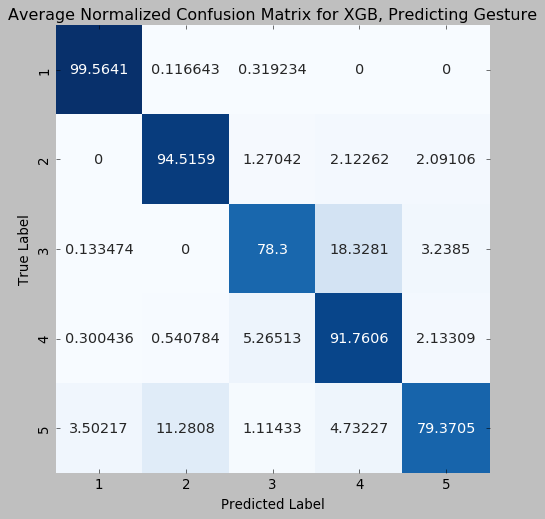

In [556]:
df_cm_xgb_sum = df_cm_xgb.add(df_cm_xgb_2, fill_value=0).add(df_cm_xgb_3, fill_value=0).add(df_cm_xgb_4, fill_value=0).add(df_cm_xgb_5, fill_value=0)
df_cm_xgb_sum_normalize = 100*df_cm_xgb_sum.astype('float') / df_cm_xgb_sum.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
plt.title("Average Normalized Confusion Matrix for XGB, Predicting Gesture")
sn.heatmap(df_cm_xgb_sum_normalize, annot=True, fmt='g', cbar=False, 
           annot_kws={"size": 13}, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.rc('xtick', labelsize= 13)    # fontsize of the tick labels
plt.rc('ytick', labelsize= 13)    # fontsize of the tick labels
plt.savefig('../figures/Average Normalized Confusion Matrix for XGB, Predicting Gesture.png',dpi=300)

#### 2.1.1.4 Local feature importance with xgboost

In [409]:
param_grid = {"learning_rate": [0.03],
                          "n_estimators": [400],
                          "seed": [random_state],
                          "reg_alpha": [0e0],
                          "reg_lambda": [10.],
                          "missing": [np.NaN], 
                          "max_depth": [6],
                          "colsample_bytree": [0.9],              
                          "subsample": [0.66], 
                          "n_jobs": [-1]}
XGB = xgboost.XGBClassifier()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(x_class_train, y_class_train, early_stopping_rounds=50, 
        eval_set=[(x_class_cv, y_class_cv)], verbose=False)
best_XGB = XGB

In [410]:
# create the explainer object with the random forest model
explainer_xgb_class = shap.TreeExplainer(best_XGB)
# transform the test set
X_test_transformed_xgb_class = x_class_test
print(np.shape(X_test_transformed_xgb_class))
# calculate shap values on the first 100 points in the test
shap_values_xgb_class = explainer_xgb_class.shap_values(X_test_transformed_xgb_class[:100])
print(np.shape(shap_values_xgb_class))

(16384, 34)
(5, 100, 34)


In [521]:
y_class_test.iloc[5, :]

Class    1
Name: 28637, dtype: int64

In [427]:
index = 5 # the index of the point to explain
print(explainer_xgb_class.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer_xgb_class.expected_value[0], shap_values_xgb_class[0][index,:], 
                features = X_test_transformed_xgb_class.iloc[index, :],feature_names = df.columns[3:], plot_cmap="PkYg")

0.57053703


In [569]:
index = 5 # the index of the point to explain
print(explainer_xgb_class.expected_value[1]) # we explain class 1 predictions
shap.force_plot(explainer_xgb_class.expected_value[1], shap_values_xgb_class[1][index,:], 
                features = X_test_transformed_xgb_class.iloc[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

0.4794292


In [429]:
index = 5 # the index of the point to explain
print(explainer_xgb_class.expected_value[2]) # we explain class 2 predictions
shap.force_plot(explainer_xgb_class.expected_value[2], shap_values_xgb_class[2][index,:], 
                features = X_test_transformed_xgb_class.iloc[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

0.654222


In [430]:
index = 5 # the index of the point to explain
print(explainer_xgb_class.expected_value[3]) # we explain class 3 predictions
shap.force_plot(explainer_xgb_class.expected_value[3], shap_values_xgb_class[3][index,:], 
                features = X_test_transformed_xgb_class.iloc[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

0.4360124


In [431]:
index = 5 # the index of the point to explain
print(explainer_xgb_class.expected_value[4]) # we explain class 4 predictions
shap.force_plot(explainer_xgb_class.expected_value[4], shap_values_xgb_class[4][index,:], 
                features = X_test_transformed_xgb_class.iloc[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

0.51471204


#### 2.1.1.5 Global feature importance with xgboost

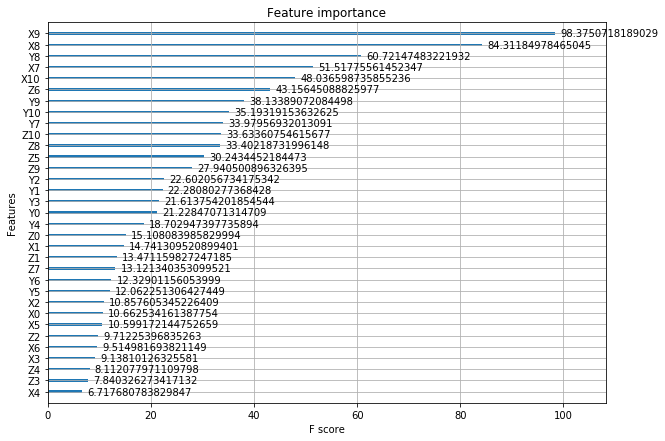

In [515]:
xgb_glb_importance = xgboost.plot_importance(best_XGB, importance_type='gain')
fig = xgb_glb_importance.figure
fig.set_size_inches(10, 7)
plt.savefig('../figures/XGB Global Feature importance, Predicting Gesture.png',dpi=300)

### 2.1.2 SVC
* Use only marker 0-4, because they almost have no missing values
* Impute missing value with random forest

#### 2.1.2.1 Split train, cv test for SVC
Split and impute data, only keep features missing less than 5%

In [372]:
rf_imputer = IterativeImputer(estimator = 
               RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                               random_state=42)

In [380]:
# User 0, 1, 2, 4, 5, 6, 7, 9, 12, 14 as train set, 57.51% of all the data
class_train_list_impute = [0, 1, 2, 4, 5, 6, 7, 9, 12, 14]
print("Train: ")
x_class_train_impute, y_class_train_impute = extract_data(class_train_list_impute, 'User', 'Class', impute=True)
x_class_train_impute = scaler_minmax.fit_transform(x_class_train_impute)
x_class_train_impute = rf_imputer.fit_transform(x_class_train_impute)
print("########################################")

# User 8, 10 as test set, 20.98% of all the data
class_test_list_impute = [8, 10]
print("Test: ")
x_class_test_impute, y_class_test_impute = extract_data(class_test_list_impute, 'User', 'Class', impute=True)
x_class_test_impute = scaler_minmax.transform(x_class_test_impute)
x_class_test_impute = rf_imputer.transform(x_class_test_impute)
print("########################################")

# User 11, 13 as test set, 21.51% of all the data
class_cv_list_impute = [11, 13]
print("CV: ")
x_class_cv_impute, y_class_cv_impute = extract_data(class_cv_list_impute, 'User', 'Class', impute=True)
x_class_cv_impute = scaler_minmax.transform(x_class_cv_impute)
x_class_cv_impute = rf_imputer.transform(x_class_cv_impute)

Train: 
proportion: 0.5750816313464371
rows: 44911
########################################
Test: 
proportion: 0.2097957615724438
rows: 16384
########################################
CV: 
proportion: 0.21512260708111916
rows: 16800


#### 2.1.2.2 Tune hyperparameters
Find the best $C$, $\gamma$ and for SVC.  

In [288]:
# tune C and gamma
Cs = np.logspace(0, 6, 5)
gammas = np.logspace(-5, 2, 5)

svc_para = {"SVC": [], "C":[], "gamma":[], "accuracy_cv":[]}
for C_train in Cs:
    for gamma_train in gammas:
        # Fit model
        sv_classif = SVC(C=C_train, gamma=gamma_train)
        sv_classif.fit(x_class_train_impute, y_class_train_impute)
        # Accuracy for cv
        y_class_cv_impute_pred = sv_classif.predict(x_class_cv_impute)
        svc_para["accuracy_cv"].append(accuracy_score(y_class_cv_impute, y_class_cv_impute_pred))
        svc_para["C"].append(C_train)
        svc_para["gamma"].append(gamma_train)
        svc_para["SVC"].append(sv_classif)
        print(f"{C_train, gamma_train} finished")

(1.0, 1e-05) finished
(1.0, 0.0005623413251903491) finished
(1.0, 0.03162277660168379) finished
(1.0, 1.7782794100389228) finished
(1.0, 100.0) finished
(31.622776601683793, 1e-05) finished
(31.622776601683793, 0.0005623413251903491) finished
(31.622776601683793, 0.03162277660168379) finished
(31.622776601683793, 1.7782794100389228) finished
(31.622776601683793, 100.0) finished
(1000.0, 1e-05) finished
(1000.0, 0.0005623413251903491) finished
(1000.0, 0.03162277660168379) finished
(1000.0, 1.7782794100389228) finished
(1000.0, 100.0) finished
(31622.776601683792, 1e-05) finished
(31622.776601683792, 0.0005623413251903491) finished
(31622.776601683792, 0.03162277660168379) finished
(31622.776601683792, 1.7782794100389228) finished
(31622.776601683792, 100.0) finished
(1000000.0, 1e-05) finished
(1000000.0, 0.0005623413251903491) finished
(1000000.0, 0.03162277660168379) finished
(1000000.0, 1.7782794100389228) finished
(1000000.0, 100.0) finished


#### 2.1.2.3 Uncertainty created by random state on splitting and final results

In [289]:
svc_para["SVC"][np.argmax(svc_para["accuracy_cv"])]    # Best SVC

SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03162277660168379,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [385]:
def uncertainty_svc_class(test, train, cv, random_st):
    """Return the result of svc model given how the user wants to split train, cv, test and random_state of random forest imputer"""
    x_class_test_impute, y_class_test_impute = extract_data(test, 'User', 'Class', impute=True, random_state=random_st)    # Split test
    x_class_train_impute, y_class_train_impute = extract_data(train, 'User', 'Class', impute=True, random_state=random_st)    # Split train
    x_class_cv_impute, y_class_cv_impute = extract_data(cv, 'User', 'Class', impute=True, random_state=random_st)    # Split cv
    rf_imputer = IterativeImputer(estimator = 
               RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                               random_state=random_st)
    x_class_train_impute = scaler_minmax.fit_transform(x_class_train_impute)
    x_class_train_impute = rf_imputer.fit_transform(x_class_train_impute)
    x_class_test_impute = scaler_minmax.transform(x_class_test_impute)
    x_class_test_impute = rf_imputer.transform(x_class_test_impute)
    x_class_cv_impute = scaler_minmax.transform(x_class_cv_impute)
    x_class_cv_impute = rf_imputer.transform(x_class_cv_impute)
    sv_classif = SVC(C=1000.0, gamma=10**(-3/2))
    sv_classif.fit(x_class_train_impute, y_class_train_impute)
    y_class_test_impute_pred_svc = sv_classif.predict(x_class_test_impute)    # Get result from test set
    return accuracy_score(y_class_test_impute, y_class_test_impute_pred_svc), pd.DataFrame(confusion_matrix(y_class_test_impute, y_class_test_impute_pred_svc), 
                                                         index=[i for i in "12345"], columns = [i for i in "12345"])

In [500]:
# 1st random state
test_1 = [0, 1]
train_1 = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
cv_1 = [13, 14]
acc_score_svc, df_cm_svc = uncertainty_svc_class(test_1, train_1, cv_1, 42)

proportion: 0.17625968371854792
rows: 13765
proportion: 0.6158652922722325
rows: 48096
proportion: 0.20787502400921953
rows: 16234


In [386]:
# 2nd random state
test_2 = [0, 1]
train_2 = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
cv_2 = [13, 14]
acc_score_svc_2, df_cm_svc_2 = uncertainty_svc_class(test_2, train_2, cv_2, 56)

proportion: 0.17625968371854792
rows: 13765
proportion: 0.6158652922722325
rows: 48096
proportion: 0.20787502400921953
rows: 16234


In [388]:
# 3rd random state
test_3 = [0, 2]
train_3 = [1, 4, 5, 6, 7, 8, 9, 10, 12, 13]
cv_3 = [11, 14]
acc_score_svc_3, df_cm_svc_3 = uncertainty_svc_class(test_3, train_3, cv_3, 65)

proportion: 0.1736474806325629
rows: 13561
proportion: 0.6271592291439912
rows: 48978
proportion: 0.1991932902234458
rows: 15556


In [389]:
# 4th random state
test_4 = [2, 13]
train_4 = [0, 1, 4, 5, 6, 7, 9, 11, 12, 14]
cv_4 = [8, 10]
acc_score_svc_4, df_cm_svc_4 = uncertainty_svc_class(test_4, train_4, cv_4, 24)

proportion: 0.16969076125232088
rows: 13252
proportion: 0.6205134771752353
rows: 48459
proportion: 0.2097957615724438
rows: 16384


In [390]:
# 5th random state
test_5 = [6, 13]
train_5 = [0, 1, 4, 5, 6, 7, 9, 10, 12, 14]
cv_5 = [8, 11]
acc_score_svc_5, df_cm_svc_5 = uncertainty_svc_class(test_5, train_5, cv_5, 78)

proportion: 0.16794929252833088
rows: 13116
proportion: 0.639874511812536
rows: 49971
proportion: 0.1904347269351431
rows: 14872


In [501]:
mean_acc_svc_class = np.mean([acc_score_svc, acc_score_svc_2, acc_score_svc_3, acc_score_svc_4, acc_score_svc_5])
std_acc_svc_class = np.std([acc_score_svc, acc_score_svc_2, acc_score_svc_3, acc_score_svc_4, acc_score_svc_5])
print(f"for class prediction, mean: {mean_acc_svc_class}, std: {std_acc_svc_class}")
print(f"{(mean_acc_svc_class-baseline_class)/std_acc_svc_class} standard deviation above baseline")

for class prediction, mean: 0.7964985298913243, std: 0.04136274955407803
14.196710115575776 standard deviation above baseline


In [506]:
[acc_score_svc, acc_score_svc_2, acc_score_svc_3, acc_score_svc_4, acc_score_svc_5]

[0.8197602615328732,
 0.8197602615328732,
 0.74183319814173,
 0.7533957138545125,
 0.8477432143946325]

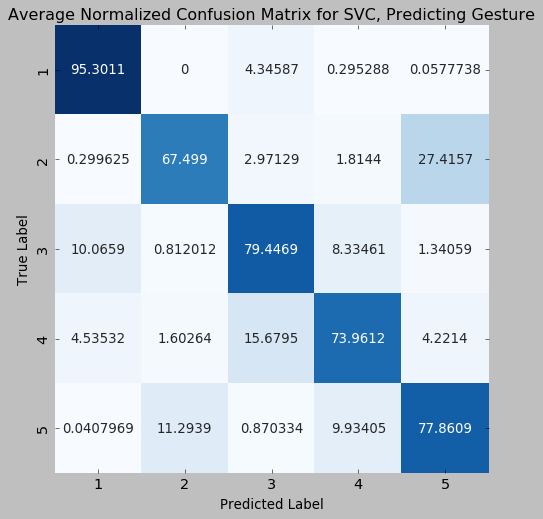

In [557]:
df_cm_svc_sum = df_cm_svc.add(df_cm_svc_2, fill_value=0).add(df_cm_svc_3, fill_value=0).add(df_cm_svc_4, fill_value=0).add(df_cm_svc_5, fill_value=0)
df_cm_svc_sum_normalize = 100*df_cm_svc_sum.astype('float') / df_cm_svc_sum.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
plt.title("Average Normalized Confusion Matrix for SVC, Predicting Gesture")
sn.heatmap(df_cm_svc_sum_normalize, annot=True, fmt='g', cbar=False, 
           annot_kws={"size": 12}, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.rc('xtick', labelsize= 13)    # fontsize of the tick labels
plt.rc('ytick', labelsize= 13)    # fontsize of the tick labels
plt.savefig('../figures/Average Normalized Confusion Matrix for SVC, Predicting Gesture.png',dpi=300)

#### 2.1.2.4 Local feature importance with svc

In [381]:
sv_classif = SVC(C=1000.0, gamma=10**(-3/2), probability=True)
sv_classif.fit(x_class_train_impute, y_class_train_impute)
best_SVC = sv_classif

In [383]:
# create the explainer object with the random forest model
explainer_svc_class = shap.KernelExplainer(model=best_SVC.predict_proba, 
                                           data=x_class_train_impute[0:10], link="logit")
# transform the test set
X_test_transformed_svc_class = x_class_test_impute
print(np.shape(X_test_transformed_svc_class))
# calculate shap values on the first 100 points in the test
shap_values_svc_class = explainer_svc_class.shap_values(X_test_transformed_svc_class[:10])
print(np.shape(shap_values_svc_class))

(16384, 16)


(5, 10, 16)


In [522]:
index = 5 # the index of the point to explain
print(explainer_svc_class.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer_svc_class.expected_value[0], shap_values_svc_class[0][index,:], 
                features = X_test_transformed_svc_class[index,:],feature_names = df.columns[3:19], plot_cmap="PkYg")

4.442050859297181


In [398]:
index = 5 # the index of the point to explain
print(explainer_svc_class.expected_value[1]) # we explain class 1 predictions
shap.force_plot(explainer_svc_class.expected_value[1], shap_values_svc_class[1][index,:], 
                features = X_test_transformed_svc_class[index,:],feature_names = df.columns[3:19], plot_cmap="PkYg")

-10.104473005063998


In [399]:
index = 5 # the index of the point to explain
print(explainer_svc_class.expected_value[2]) # we explain class 2 predictions
shap.force_plot(explainer_svc_class.expected_value[2], shap_values_svc_class[2][index,:], 
                features = X_test_transformed_svc_class[index,:],feature_names = df.columns[3:19], plot_cmap="PkYg")

-4.4479912425968715


In [400]:
index = 5 # the index of the point to explain
print(explainer_svc_class.expected_value[3]) # we explain class 3 predictions
shap.force_plot(explainer_svc_class.expected_value[3], shap_values_svc_class[3][index,:], 
                features = X_test_transformed_svc_class[index,:],feature_names = df.columns[3:19], plot_cmap="PkYg")

-10.60750191658038


In [401]:
index = 5 # the index of the point to explain
print(explainer_svc_class.expected_value[4]) # we explain class 4 predictions
shap.force_plot(explainer_svc_class.expected_value[4], shap_values_svc_class[4][index,:], 
                features = X_test_transformed_svc_class[index,:],feature_names = df.columns[3:19], plot_cmap="PkYg")

-12.903402978013153


## 2.2 Training Models for User

### 2.2.1 xgboost

#### 2.2.1.1 Find the best gesture, tune corresponding hyperparameters
Predict the user given a certain class of gesture. Tune hyperparameters $\alpha$, $\lambda$ and `max_depth` for every gesture. Find the best gesture based on test accuracy scores.  

In [465]:
def predict_user_given_class_xgb(df_user_x, df_user_y, random_state=42):
    """Return the best xgb model, test score and records of tuning hyperparameters"""
    num_ftrs = df.columns[2:]    # Categorical features
    
    # Standard scaler
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

    # collect the transformers
    preprocessor = ColumnTransformer(remainder='passthrough', 
        transformers=[('num', numeric_transformer, num_ftrs),])
    X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                        test_size=0.2, random_state=random_state, stratify=df_user_y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                        test_size=0.2, random_state=random_state, stratify=y_other)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X_cv = preprocessor.transform(X_cv)
    
    # Tune parameters
    xgb_para = {"XGB": [], "lambda": [], "depth": [], "accuracy_cv": []}
    for lbd in [0e0, 1., 10.0, 20.0, 50.0]:
        for depth in [4, 5, 6, 7, 8]:
            param_grid = {"learning_rate": [0.03],
                          "n_estimators": [400],
                          "seed": [random_state],
                          "reg_alpha": [0e0],
                          "reg_lambda": [lbd],
                          "missing": [np.NaN], 
                          "max_depth": [depth],
                          "colsample_bytree": [0.9],              
                          "subsample": [0.66], 
                          "n_jobs": [-1]}
            XGB = xgboost.XGBClassifier()
            XGB.set_params(**ParameterGrid(param_grid)[0])
            XGB.fit(X_train[:500], y_train[:500], early_stopping_rounds=50, 
                    eval_set=[(X_cv[:50], y_cv[:50])], verbose=False)
            y_cv_pred = XGB.predict(X_cv[:50])
            xgb_para["accuracy_cv"].append(accuracy_score(y_cv[:50], y_cv_pred))
            xgb_para["XGB"].append(XGB)
            xgb_para["lambda"].append(lbd)
            xgb_para["depth"].append(depth)
    
    # Get the best xgb model
    best_XGB = xgb_para["XGB"][np.argmax(xgb_para["accuracy_cv"])]
    y_test_pred = best_XGB.predict(X_test)
    score = accuracy_score(y_test, y_test_pred)
    return best_XGB, score, xgb_para

In [466]:
user_pred = {"XGB": [], "class": [], "shape": [], "score": [], "para_log": []}
for i in range(1, 6):
    user_pred["class"].append(i)
    df_user = df[df['Class'] == i].drop('Class', axis=1)    # Extracting data from Class i
    df_user_x = df_user.drop('User', axis=1)    # Extract x
    df_user_y = df_user[['User']]    # Extract y
    # Model and score of prediction using Class i
    xgb_model, score, para_log = predict_user_given_class_xgb(df_user_x, df_user_y)
    # Record models, score and parameter tuning logs
    user_pred["XGB"].append(xgb_model)
    user_pred["score"].append(score)
    user_pred["shape"].append((df_user_x.shape, df_user_y.shape))
    user_pred["para_log"].append(para_log)
    print(f"Class {i} finished")
    print()

print(user_pred["class"][np.argmax(user_pred["score"])])

Class 1 finished
Class 2 finished
Class 3 finished
Class 4 finished
Class 5 finished
5


The best gesture for recognizing users using xgboost is `Class 5`, which is "grab".  

#### 2.2.1.2 Uncertainty created by random state on splitting and xgboost and final results

In [467]:
# Best parameters from grid search
user_pred["XGB"][np.argmax(user_pred["score"])]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.66, verbosity=1)

In [469]:
def uncertainty_xgb_user(random_state):
    num_ftrs = df.columns[2:]    # Categorical features
    # Standard scaler
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    # collect the transformers
    preprocessor = ColumnTransformer(remainder='passthrough', 
        transformers=[('num', numeric_transformer, num_ftrs),])
    X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                        test_size=0.2, random_state=random_state, stratify=df_user_y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                        test_size=0.2, random_state=random_state, stratify=y_other)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X_cv = preprocessor.transform(X_cv)
    param_grid = {"learning_rate": [0.03],
                              "n_estimators": [400],
                              "seed": [random_state],
                              "reg_alpha": [0.0],
                              "reg_lambda": [0.0],
                              "missing": [np.NaN], 
                              "max_depth": [6],
                              "colsample_bytree": [0.9],              
                              "subsample": [0.66], 
                              "n_jobs": [-1]}
    XGB = xgboost.XGBClassifier()
    XGB.set_params(**ParameterGrid(param_grid)[0])
    XGB.fit(X_train, y_train, early_stopping_rounds=50, 
            eval_set=[(X_cv, y_cv)], verbose=False)
    y_test_pred = XGB.predict(X_test)
    return accuracy_score(y_test, y_test_pred), pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                                                 index=set(y_test["User"]), columns=set(y_test["User"]))

In [484]:
df_user = df[df['Class'] == 5].drop('Class', axis=1)    # Extracting data from Class i
df_user_x = df_user.drop('User', axis=1)    # Extract x
df_user_y = df_user[['User']]    # Extract y
acc_score_xgb_user, df_cm_xgb_user = uncertainty_xgb_user(42)
acc_score_xgb_user_2, df_cm_xgb_user_2 = uncertainty_xgb_user(45)
acc_score_xgb_user_3, df_cm_xgb_user_3 = uncertainty_xgb_user(49)
acc_score_xgb_user_4, df_cm_xgb_user_4 = uncertainty_xgb_user(54)
acc_score_xgb_user_5, df_cm_xgb_user_5 = uncertainty_xgb_user(68)

In [485]:
mean_acc_xgb_user = np.mean([acc_score_xgb_user, acc_score_xgb_user_2, acc_score_xgb_user_3, acc_score_xgb_user_4, acc_score_xgb_user_5])
std_acc_xgb_user = np.std([acc_score_xgb_user, acc_score_xgb_user_2, acc_score_xgb_user_3, acc_score_xgb_user_4, acc_score_xgb_user_5])
print(f"for user prediction, mean: {mean_acc_xgb_user}, std: {std_acc_xgb_user}")
print(f"{(mean_acc_xgb_user-baseline_user)/std_acc_xgb_user} standard deviation above baseline")

for user prediction, mean: 0.9963775023832222, std: 0.0012962235814662475
674.109037662961 standard deviation above baseline


In [486]:
[acc_score_xgb_user, acc_score_xgb_user_2, acc_score_xgb_user_3, acc_score_xgb_user_4, acc_score_xgb_user_5]

[0.9955513187162377,
 0.9968223705115984,
 0.9974578964092787,
 0.994280266920877,
 0.9977756593581188]

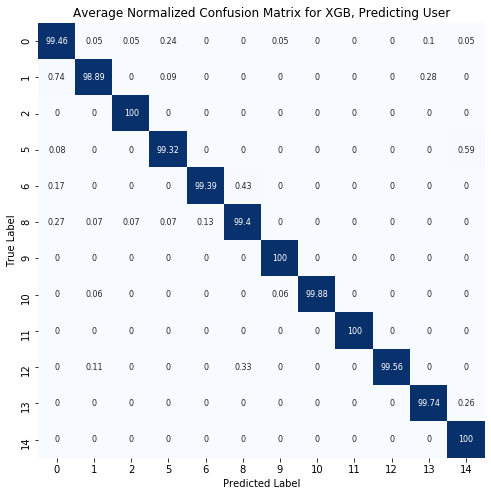

In [487]:
df_cm_xgb_sum_user = df_cm_xgb_user.add(df_cm_xgb_user_2, fill_value=0).add(
                df_cm_xgb_user_3, fill_value=0).add(df_cm_xgb_user_4, fill_value=0).add(df_cm_xgb_user_5, fill_value=0)
df_cm_xgb_sum_user_normalize = 100*df_cm_xgb_sum_user.astype('float') / df_cm_xgb_sum_user.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (8, 8))
plt.title("Average Normalized Confusion Matrix for XGB, Predicting User")
sn.heatmap(df_cm_xgb_sum_user_normalize.round(decimals=2), annot=True, fmt='g', cbar=False, 
           annot_kws={"size": 8}, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('../figures/Average Normalized Confusion Matrix for XGB, Predicting User.png',dpi=300)

#### 2.2.1.3 Local feature importance with xgboost

In [488]:
random_state = 42
num_ftrs = df.columns[2:]    # Categorical features
# Standard scaler
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
# collect the transformers
preprocessor = ColumnTransformer(remainder='passthrough', 
    transformers=[('num', numeric_transformer, num_ftrs),])
X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                    test_size=0.2, random_state=random_state, stratify=df_user_y)
X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                    test_size=0.2, random_state=random_state, stratify=y_other)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_cv = preprocessor.transform(X_cv)
param_grid = {"learning_rate": [0.03],
                          "n_estimators": [400],
                          "seed": [random_state],
                          "reg_alpha": [0.0],
                          "reg_lambda": [0.0],
                          "missing": [np.NaN], 
                          "max_depth": [6],
                          "colsample_bytree": [0.9],              
                          "subsample": [0.66], 
                          "n_jobs": [-1]}
XGB = xgboost.XGBClassifier()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(X_train, y_train, early_stopping_rounds=50, 
        eval_set=[(X_cv, y_cv)], verbose=False)
xgb_user_class_5 = XGB

In [493]:
# create the explainer object with the random forest model
explainer_xgb_user = shap.TreeExplainer(xgb_user_class_5)
# transform the test set
X_test_transformed_xgb_user = scaler_minmax.transform(x_user_test)
print(np.shape(X_test_transformed_xgb_user))
# calculate shap values on the first 100 points in the test
shap_values_xgb_user = explainer_xgb_user.shap_values(X_test_transformed_xgb_user[:100])
print(np.shape(shap_values_xgb_user))

(3147, 34)
(12, 100, 34)


In [565]:
index = 8 # the index of the point to explain
print(explainer_xgb_user.expected_value[0]) # we explain user 0 predictions
shap.force_plot(explainer_xgb_user.expected_value[0], shap_values_xgb_user[0][index,:], 
                features = X_test_transformed_xgb_user[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

1.2248781


In [564]:
index = 8 # the index of the point to explain
print(explainer_xgb_user.expected_value[1]) # we explain user 1 predictions
shap.force_plot(explainer_xgb_user.expected_value[1], shap_values_xgb_user[1][index,:], 
                features = X_test_transformed_xgb_user[index,:],feature_names = df.columns[3:], plot_cmap="PkYg")

0.49813682


#### 2.2.1.4 Global feature importance with xgboost

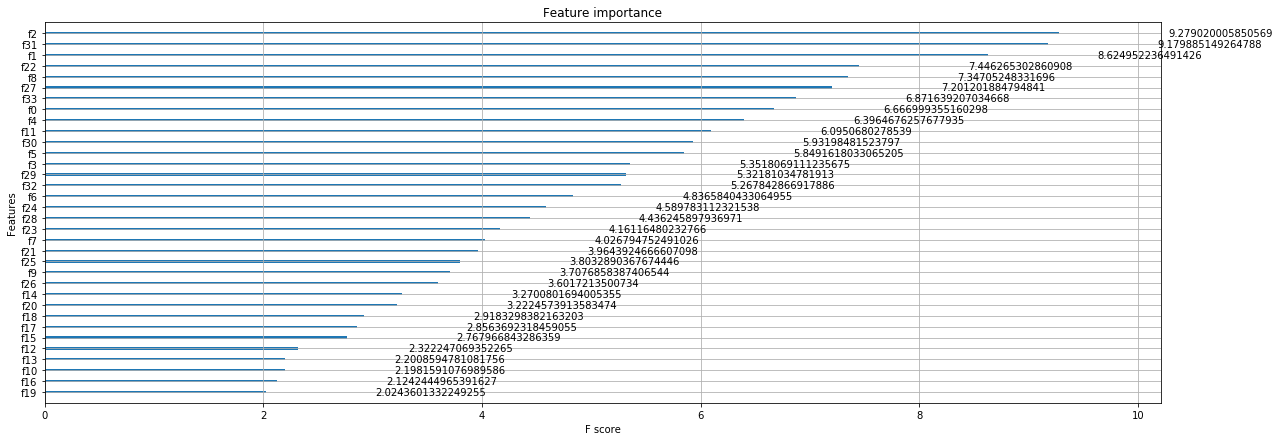

In [519]:
xgb_glb_importance = xgboost.plot_importance(xgb_user_class_5, importance_type='gain')
fig = xgb_glb_importance.figure
fig.set_size_inches(20, 7)
plt.savefig('../figures/XGB Global Feature importance, Predicting Users.png',dpi=300)

### 2.2.2 SVC

#### 2.2.2.1 Find the best gesture, tune corresponding hyperparameters

In [213]:
def predict_user_given_class_svc(df_user_x, df_user_y, random_state=42):
    """Return the best xgb model, test score and records of tuning hyperparameters"""
    num_ftrs = df_user_x.columns[2:]    # Categorical features
    # Standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()), 
        ('imputer', IterativeImputer(estimator = 
           RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                           random_state=random_state))])
    # collect the transformers
    preprocessor = ColumnTransformer(remainder='passthrough', 
        transformers=[('num', numeric_transformer, num_ftrs),])
    X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                        test_size=0.2, random_state=random_state, stratify=df_user_y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                        test_size=0.2, random_state=random_state, stratify=y_other)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X_cv = preprocessor.transform(X_cv)
    # tune C and gamma
    Cs = np.logspace(0, 6, 5)
    gammas = np.logspace(-5, 2, 5)
    svc_para = {"SVC": [], "C":[], "gamma":[], "accuracy_cv":[]}
    for C_train in Cs:
        for gamma_train in gammas:
            # Fit model
            sv_classif = SVC(C=C_train, gamma=gamma_train)
            sv_classif.fit(X_train, y_train)
            # Accuracy for cv
            y_cv_pred = sv_classif.predict(X_cv)
            svc_para["accuracy_cv"].append(accuracy_score(y_cv, y_cv_pred))
            svc_para["C"].append(C_train)
            svc_para["gamma"].append(gamma_train)
            svc_para["SVC"].append(sv_classif)
    # Get the best SVC model
    best_SVC = svc_para["SVC"][np.argmax(svc_para["accuracy_cv"])]
    y_test_pred = best_SVC.predict(X_test)
    score = accuracy_score(y_test, y_test_pred)
    return best_SVC, score, svc_para, X_test, y_test

In [226]:
user_pred_svc = {"SVC": [], "class": [], "shape": [], "score": [], "para_log": [], "X_test": [], "y_test": []}
for i in range(1, 6):
    user_pred_svc["class"].append(i)
    df_user = df[df['Class'] == i][impute_feat].drop('Class', axis=1)    # Extracting data from Class i
    df_user_x = df_user.drop('User', axis=1)    # Extract x
    df_user_y = df_user[['User']]    # Extract y
    # Model and score of prediction using Class i
    svc_model, score, para_log, X_test_svc, y_test_svc = predict_user_given_class_svc(df_user_x, df_user_y)
    # Record models, score and parameter tuning logs
    user_pred_svc["SVC"].append(svc_model)
    user_pred_svc["score"].append(score)
    user_pred_svc["shape"].append((df_user_x.shape, df_user_y.shape))
    user_pred_svc["para_log"].append(para_log)
    user_pred_svc["X_test"].append(X_test_svc)
    user_pred_svc["y_test"].append(y_test_svc)
    print(f"Class {i} finished")

print(user_pred_svc["class"][np.argmax(user_pred_svc["score"])])

Class 1 finished
Class 2 finished
Class 3 finished
Class 4 finished
Class 5 finished
4


The best gesture for recognizing users using SVC is `Class 4`, which is "point with two fingers".  

#### 2.2.2.2 Uncertainty created by random state on splitting and final results

In [215]:
# Best parameters from grid search
user_pred_svc["SVC"][np.argmax(user_pred_svc["score"])]

SVC(C=31.622776601683793, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03162277660168379,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [477]:
def uncertainty_svc_user(random_state):
    """Return accuracy and confusion matrix for predicting user using svc, given random_state"""
    df_user = df[df['Class'] == 4][impute_feat].drop('Class', axis=1)    # Extracting data from Class 4
    df_user_x = df_user.drop('User', axis=1)    # Extract x
    df_user_y = df_user[['User']]    # Extract y
    num_ftrs = df_user_x.columns[2:]    # Categorical features
    # Standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()), 
        ('imputer', IterativeImputer(estimator = 
           RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                           random_state=random_state))])
    # collect the transformers
    preprocessor = ColumnTransformer(remainder='passthrough', 
        transformers=[('num', numeric_transformer, num_ftrs),])
    X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                        test_size=0.2, random_state=random_state, stratify=df_user_y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                        test_size=0.2, random_state=random_state, stratify=y_other)
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X_cv = preprocessor.transform(X_cv)
    sv_classif = SVC(C=10**(1.5), gamma=10**(-3/2))
    sv_classif.fit(X_train, y_train)
    y_user_test_pred_svc = sv_classif.predict(X_test)
    return accuracy_score(y_test, y_user_test_pred_svc), pd.DataFrame(confusion_matrix(y_test, y_user_test_pred_svc), 
                                                 index=set(y_test["User"]), columns=set(y_test["User"]))

In [489]:
acc_score_svc_user, df_cm_svc_user = uncertainty_svc_user(42)
acc_score_svc_user_2, df_cm_svc_user_2 = uncertainty_svc_user(45)
acc_score_svc_user_3, df_cm_svc_user_3 = uncertainty_svc_user(49)
acc_score_svc_user_4, df_cm_svc_user_4 = uncertainty_svc_user(54)
acc_score_svc_user_5, df_cm_svc_user_5 = uncertainty_svc_user(68)

In [490]:
mean_acc_svc_user = np.mean([acc_score_svc_user, acc_score_svc_user_2, acc_score_svc_user_3, acc_score_svc_user_4, acc_score_svc_user_5])
std_acc_svc_user = np.std([acc_score_svc_user, acc_score_svc_user_2, acc_score_svc_user_3, acc_score_svc_user_4, acc_score_svc_user_5])
print(f"for user prediction, mean: {mean_acc_svc_user}, std: {std_acc_svc_user}")
print(f"{(mean_acc_svc_user-baseline_user)/std_acc_svc_user} standard deviation above baseline")

for user prediction, mean: 0.9767174280879865, std: 0.0006902226075929089
1237.4789631735443 standard deviation above baseline


In [491]:
[acc_score_svc_user, acc_score_svc_user_2, acc_score_svc_user_3, acc_score_svc_user_4, acc_score_svc_user_5]

[0.977326565143824,
 0.9766497461928934,
 0.9759729272419628,
 0.9776649746192894,
 0.9759729272419628]

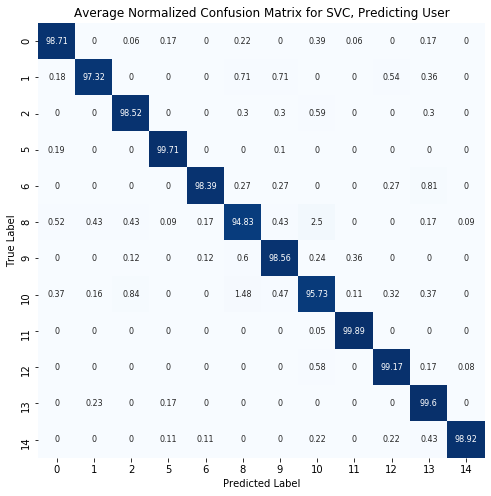

In [534]:
df_cm_svc_sum_user = df_cm_svc_user.add(df_cm_svc_user_2, fill_value=0).add(
                df_cm_svc_user_3, fill_value=0).add(df_cm_svc_user_4, fill_value=0).add(df_cm_svc_user_5, fill_value=0)
df_cm_svc_sum_user_normalize = 100*df_cm_svc_sum_user.astype('float') / df_cm_svc_sum_user.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (8, 8))
plt.title("Average Normalized Confusion Matrix for SVC, Predicting User")
sn.heatmap(df_cm_svc_sum_user_normalize.round(decimals=2), annot=True, fmt='g', cbar=False, 
           annot_kws={"size": 8}, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('../figures/Average Normalized Confusion Matrix for SVC, Predicting User.png',dpi=300)

#### 2.2.2.3 Local feature importance with svc

In [378]:
random_state = 42
df_user = df[df['Class'] == 4][impute_feat].drop('Class', axis=1)    # Extracting data from Class 4
df_user_x = df_user.drop('User', axis=1)    # Extract x
df_user_y = df_user[['User']]    # Extract y
num_ftrs = df_user_x.columns[2:]    # Categorical features
# Standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()), 
    ('imputer', IterativeImputer(estimator = 
       RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                       random_state=random_state))])
# collect the transformers
preprocessor = ColumnTransformer(remainder='passthrough', 
    transformers=[('num', numeric_transformer, num_ftrs),])
X_other, X_test, y_other, y_test = train_test_split(df_user_x, df_user_y, 
                                    test_size=0.2, random_state=random_state, stratify=df_user_y)
X_train, X_cv, y_train, y_cv = train_test_split(X_other, y_other, 
                                    test_size=0.2, random_state=random_state, stratify=y_other)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_cv = preprocessor.transform(X_cv)
sv_classif = SVC(C=10**(1.5), gamma=10**(-3/2))
sv_classif.fit(X_train, y_train)
svc_user_class_4 = sv_classif

In [231]:
# create the explainer object with the random forest model
explainer_svc_user = shap.KernelExplainer(model=svc_user_class_4.predict_proba, 
                                           data=X_test[:10], link="logit")
# transform the test set
X_test_transformed_svc_user = preprocessor.transform(X_test)
print(np.shape(X_test_transformed_svc_user))
# calculate shap values on the first 100 points in the test
shap_values_svc_user = explainer_svc_user.shap_values(X_test_transformed_svc_user[:10])
print(np.shape(shap_values_svc_user))

(2955, 16)


(14, 10, 16)


In [232]:
index = 7 # the index of the point to explain
print(explainer_svc_user.expected_value[0]) # we explain user 0 predictions
shap.force_plot(explainer_svc_user.expected_value[0], shap_values_svc_user[0][index,:], 
                features = X_test_transformed_svc_user[index,:],feature_names = x_class_test_impute.columns[3:], plot_cmap="PkYg")

-2.1856363270181833


In [233]:
index = 7 # the index of the point to explain
print(explainer_svc_user.expected_value[1]) # we explain user 1 predictions
shap.force_plot(explainer_svc_user.expected_value[1], shap_values_svc_user[1][index,:], 
                features = X_test_transformed_svc_user[index,:],feature_names = x_class_test_impute.columns[3:], plot_cmap="PkYg")

-6.920897704166286
